In [187]:
import astropy
from astropy.table import Table, QTable, Column
from astropy.units import Quantity
from astropy import units as u
from astropy import constants as consts
from progress_bar import progress_bar
import numpy as np
from datetime import datetime as dt
from datetime import timezone
from matplotlib import pyplot as plt
from matplotlib import axes as mplax
from scipy.signal import argrelmin
from scipy.optimize import curve_fit
from copy import deepcopy
from sklearn.cluster import KMeans

plt.rcParams['figure.dpi'] = 150
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = '\n'.join(
                                        [r'\usepackage{siunitx}',
                                         r'\DeclareSIUnit{\angstrom}{\text {Å}}',
                                         r'\centering',
                                         r'\usepackage[version=4]{mhchem}'])

In [2]:
si2 = 6356*u.Angstrom

In [3]:
spectra = Table.read('wiserep_spectra.csv', format='csv', encoding='utf8')

In [4]:
objects = Table.read('wiserep_objects.csv', format='csv', encoding='utf8')

In [ ]:
#downloading spectra from wiserep gives all spectra, not just peak. Have to compare it to the objects table to find which spectrum is closest to the peak
used_spec_cols = [
    'Obj. ID',
    'IAU name',
    'Obj. Type',
    'Redshift',
    'Ascii file',
    'Obs-date'
]

month_in_sec = 1 * 30 * 24 * 60 * 60

#create new table to merge objects into
peak_light_spectra: Table = Table()
for column in used_spec_cols:
    peak_light_spectra[column] = []
    peak_light_spectra[column].dtype = spectra[column].dtype
peak_light_spectra['Peak-light date'] = []
peak_light_spectra['Peak-light date'].dtype = objects['Peak-light date'].dtype

wiserep_time_format = '%Y-%m-%d %H:%M:%S'

#find spectrum with the lowest difference between its peak-light date and spectrum date for each object in the observed data table
for i, obj in enumerate(objects):
    matches = spectra[spectra['Obj. ID'] == obj['Obj. ID']]
    if matches and obj['Peak-light date']:
        peak_time = dt.strptime(obj['Peak-light date'].split('.')[0], wiserep_time_format).replace(tzinfo=timezone.utc).timestamp()
        spec_times = np.array([dt.strptime(m['Obs-date'].split('.')[0], wiserep_time_format).replace(tzinfo=timezone.utc).timestamp() for m in matches])
        delta_time = np.abs(peak_time - spec_times) 
        if (len(spec_times) > 0) and (np.min(delta_time) <= month_in_sec):
            peak_light_spectra.add_row(vals=[*[matches[np.argmin(delta_time)][column] for column in used_spec_cols], obj['Peak-light date']])

In [6]:
peak_light_spectra

Obj. ID,IAU name,Obj. Type,Redshift,Ascii file,Obs-date,Peak-light date
int64,str11,str15,float64,str83,str22,str22
5212,SN 2025hxf,SN Ia,0.026,PTF11bof_2011-04-11_00-00-00_Mayall_RC-Spec_PTF.flm,2011-04-11 00:00:00.00,2011-03-21 00:00:00.00
19764,SN 2021aefx,SN Ia,0.005,2021aefx_2021-11-28.12_Gemini-S_GMOS-S_None.ascii,2021-11-28 02:52:48.00,2021-11-28 12:57:36.00
5324,SN 2021qtn,SN Ia,0.064,PTF10lya_2010-06-29_00-00-00_Gemini-S_GMOS-S_PTF.ascii,2010-06-29 00:00:00.00,2010-07-06 00:00:00.00
10061,SN 2018evt,SN Ia,0.029,SN2018evt_2018-08-12_23-59-20_ESO-NTT_EFOSC2-NTT_PESSTO_SSDR1-4.csv,2018-08-12 23:59:20.00,2018-08-22 00:00:00.00
1084,SN 2018aoz,SN Ia,0.0058,2018aoz_2018-04-11_13-05-00.00_FTS_FLOYDS-S_None.ascii,2018-04-11 13:05:00.00,2018-04-13 09:50:24.00
4095,SN 2017cbv,SN Ia,0.003999,2017cbv_2017-03-26_Magellan-Baade_FIRE_None.dat,2017-03-26 00:00:00.00,2017-03-26 00:00:00.00
6683,SN 2016fod,SN Ia,0.06,2016fod_2016-09-06_07-38-53_P60_SEDM_None.ascii,2016-09-06 07:38:53.00,2016-09-01 00:00:00.00
8947,SN 2016flo,SN Ia,0.065,2016flo_2016-08-28_07-27-14_P60_SEDM_None.ascii,2016-08-28 07:27:14.00,2016-08-26 00:00:00.00
6070,SN 2016fik,SN Ia,0.11,2016fik_2016-08-26_08-43-22_P200_DBSP_None.ascii,2016-08-26 08:43:22.00,2016-08-12 00:00:00.00


In [ ]:
#functions in order to analyze spectra and verify that they are not too noisy/low resolution
def signal_to_noise(data: np.ndarray):
    mean = data.sum(0)/len(data)
    chi2 = ((data-mean)**2).sum()
    stddev = (chi2/(len(data)-1))**0.5
    s2n = (mean/stddev)**2
    return s2n
def calculate_intervals(x: np.ndarray):
    return  x[1:] - x[0:len(x)-1]

calculate_intervals(np.array([0, 1, 1, 2, 3, 5, 8, 13]))

array([1, 0, 1, 1, 2, 3, 5])

$$\frac{\lambda_0 - \lambda}{\lambda} = z$$
$$\lambda = \lambda_0(z+1)$$

In [11]:
def calculate_redshift(observed: float, emitted: float):
    return (observed - emitted) / emitted

def redshift_to_velocity(z, particle_velocity = consts.c):
    return z * particle_velocity

In [12]:
redshift_to_velocity(calculate_redshift(5500*u.Angstrom, si2))

<Quantity -40374818.13215859 m / s>

In [ ]:
#define set of functions that smooth data (acts as convolution with gaussian kernel)
def gaussian(x, x0 = 0, sigma = 1):
    curve = np.exp((-(x-x0)**2)/(2*sigma**2))
    return curve / curve.sum(axis=1)[np.newaxis]

def gaussian_filter(x, x0, y, sigma):
    gauss = gaussian(x, x0, sigma)
    return (y * gauss).sum(axis=1)

def smooth_data(x, y, sigma):
    return gaussian_filter(x, x[:, np.newaxis], y, sigma).T

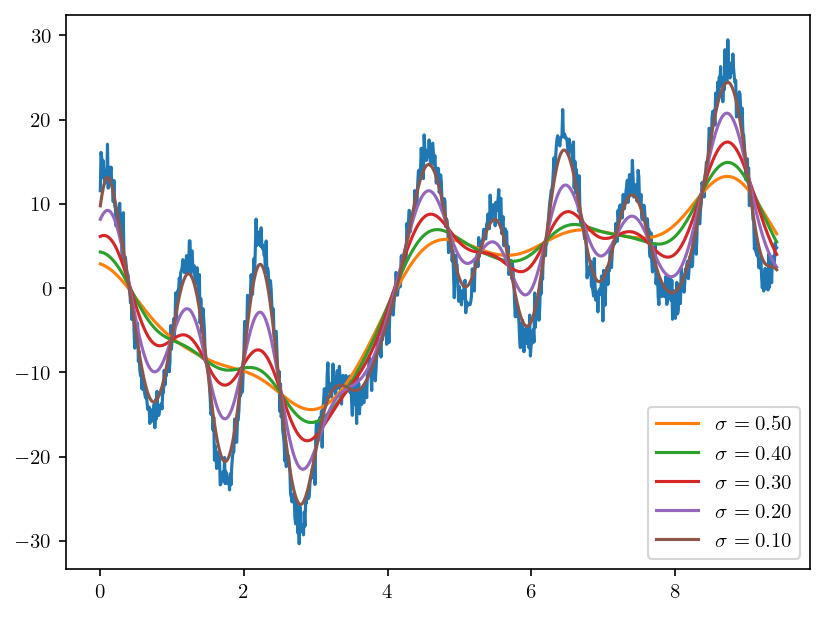

In [ ]:
#test smoothing function on randomized noisy data
tx = np.arange(0, 3*np.pi, .01)
ty = np.sum([np.random.uniform(0, 10) * np.sin(np.random.uniform(-3*np.pi, 3*np.pi)*tx + np.random.uniform(0, 2*np.pi))+np.random.normal(0, 0.5, len(tx)) for i in range(np.random.randint(1, 10))], axis=0)
plt.plot(tx, ty)
for i in range(5, 0, -1):
    smoothed = smooth_data(tx, ty, i*0.1)
    plt.plot(tx, smoothed, label=rf'$\sigma={i*0.1: .2f}$')
plt.legend()

In [ ]:
success_count = 0
smooth_sigma = 10
analyzed_spectra: Table = deepcopy(peak_light_spectra)
new_col_names = ['Ejecta Redshift', 'Mean Resolution', 'Signal to Noise']
new_cols = [Column([np.nan]*len(peak_light_spectra), name=name, dtype=np.float64) for name in new_col_names]
analyzed_spectra.add_columns(new_cols)

#write important data about spectra to a file so that I don't have to repeat calcultions every time I want to analyze
for i in range(len(peak_light_spectra)):
    file = f'wiserep_data/{peak_light_spectra['Ascii file'][i]}'
    try:
        spec: Table = Table.read(f'{file}', format='ascii')
        spec: QTable = QTable([spec.columns[0], spec.columns[1]], names=['Wavelength', 'Flux'], units=[u.Angstrom, None])
        
        success_count += 1
        analyzed_spectra['Mean Resolution'][i] = calculate_intervals(spec['Wavelength']).to_value().mean()
        analyzed_spectra['Signal to Noise'][i] = signal_to_noise(spec['Flux'])

        z = peak_light_spectra['Redshift'][i]
        spec['Wavelength'] *= (z+1) #translate the Wavelengths to what they would be if the progenitor had 0 radial velocity
        if (np.max(spec['Wavelength']) >= si2) & (np.min(spec['Wavelength']) < si2):
            while analyzed_spectra['Mean Resolution'][i] < 0.1: #some spectra with higher resolution than necessary causing memory issues
                spec = spec[[bool(i%2) for i in range(len(spec))]]
                analyzed_spectra['Mean Resolution'] = calculate_intervals(spec['Wavelength']).to_value().mean()

            spec = spec[(spec['Wavelength'] >= 5500*u.Angstrom) & (spec['Wavelength'] <= si2+20*u.Angstrom)]
            spec['Flux'] /= spec['Flux'][-1] #scale flux around the flux of the Si II line
            spec['Flux'] = smooth_data(spec['Wavelength'].to_value(), spec['Flux'], smooth_sigma)
            spec = spec[spec['Wavelength'] <= si2]

            minima = argrelmin(spec['Flux'], order=10)
            if (len(minima[0]) > 0):
                absorption_line = spec['Wavelength'][minima[0][-1]]
                analyzed_spectra['Ejecta Redshift'][i] = calculate_redshift(absorption_line, si2)
    except Exception as e:
        if isinstance(e, (astropy.io.ascii.InconsistentTableError, TypeError, UnicodeDecodeError, FileNotFoundError)):
            pass #these particular errors seem to be out of my control. I don't like ignoring the TypeError because multiple things can cause it, but there is one very esoteric one from numpy that I can't seem to solve
        else:
            raise e
    progress_bar(i+1, len(peak_light_spectra), 100)

analyzed_spectra.write('analyzed_spectra.csv', overwrite=True)

 100.00% - 1613/1613 |████████████████████████████████████████████████████████████████████████████████████████████████████|


In [14]:
read_analyzed_spectra = Table.read('analyzed_spectra.csv', format='csv', encoding='utf8')

In [186]:
sn_types = ['SN Ia', 'SN Ia-91bg-like', 'SN Ia-91T-like']
data_by_type = [read_analyzed_spectra[read_analyzed_spectra['Obj. Type'] == t] for t in sn_types]
print([len(i) for i in data_by_type])

[1609, 2, 2]


In [ ]:
#filter out noisy/low resolution data
min_s2n, max_r = 6, 5
def metadata_filter(row, min_s2n, max_r):
    return ((row['Signal to Noise'] > min_s2n) and (row['Mean Resolution'] < max_r) and not np.isnan(row['Ejecta Redshift']))
good_data = Table(read_analyzed_spectra[0], names=read_analyzed_spectra.colnames)
good_data.remove_row(0)
for spec in read_analyzed_spectra:
    if metadata_filter(spec, min_s2n, max_r):
        good_data.add_row(spec)
len(good_data)

*Plot to show difference after filtering metadata.*

 100.00% - 1613/1613 |████████████████████|


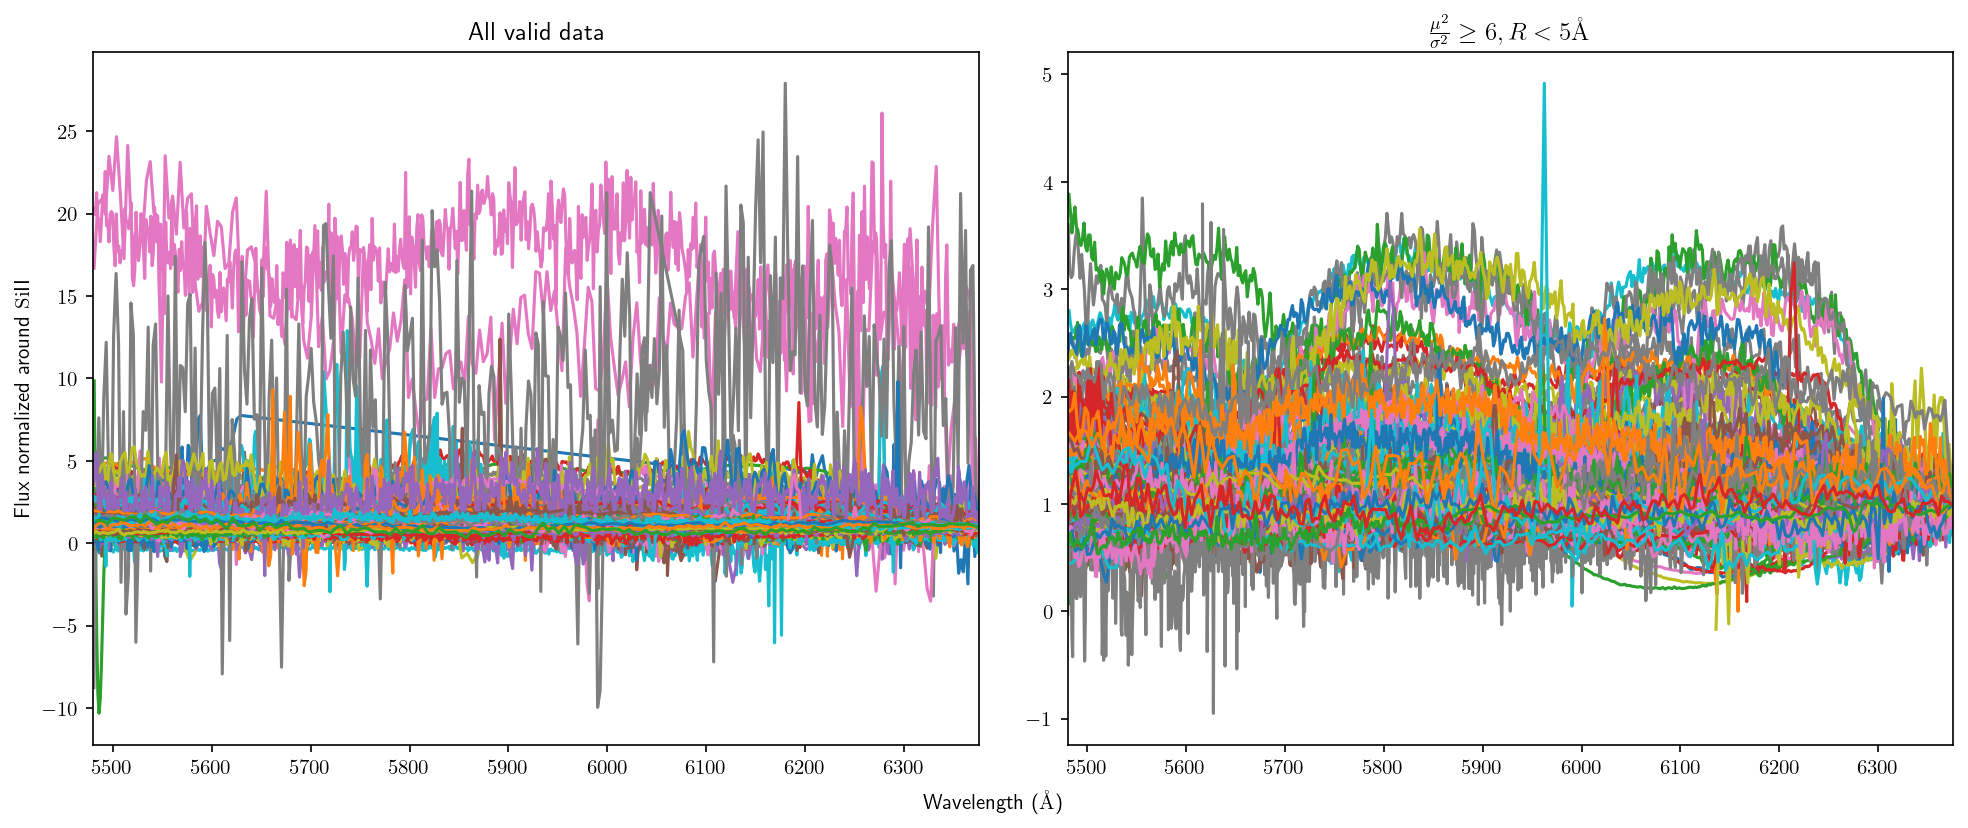

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(wspace=0.1)
axs[0].margins(x=0)
axs[1].margins(x=0)

axs[0].set_title("All valid data")
axs[1].set_title(r"$\frac{\mu^2}{\sigma^2}\geq"+f'{min_s2n}, R<{max_r}'+r"\unit{\angstrom}$")
fig.text(0.5, 0.04, r'Wavelength ($\unit{\angstrom}$)', ha='center')
axs[0].set_ylabel(r'Flux normalized around $\ce{Si}\text{II}$')
for i, row in enumerate(read_analyzed_spectra):
    try:
        z = float(row['Redshift'])
        file = f'wiserep_data/{row['Ascii file']}'
        spec: Table = Table.read(f'{file}', format='ascii')
        spec: QTable = QTable([spec.columns[0], spec.columns[1]], names=['Wavelength', 'Flux'], units=[u.Angstrom, None])
        while read_analyzed_spectra['Mean Resolution'][i] < 0.1: #some spectra with higher resolution than necessary causing memory issues
            spec = spec[[bool(i%2) for i in range(len(spec))]]
            read_analyzed_spectra['Mean Resolution'] = calculate_intervals(spec['Wavelength']).to_value().mean()
        spec['Wavelength'] *= (z + 1)
        spec = spec[(spec['Wavelength'] >= (5500-20)*u.Angstrom) & (spec['Wavelength'] <= si2+20*u.Angstrom)]
        if len(spec['Flux']) > 0:
            spec['Flux'] /= spec['Flux'][-1] #scale flux around the flux of the Si II line
            axs[0].plot(spec['Wavelength'], spec['Flux'])
            if metadata_filter(row, min_s2n, max_r):
                axs[1].plot(spec['Wavelength'], spec['Flux'])
    except (TypeError, ValueError, FileNotFoundError, astropy.io.ascii.InconsistentTableError, MemoryError) as e:
        pass
    progress_bar(i+1, len(read_analyzed_spectra), 20)
plt.savefig('filtered_spectra.png')

 100.00% - 270/270 |████████████████████|


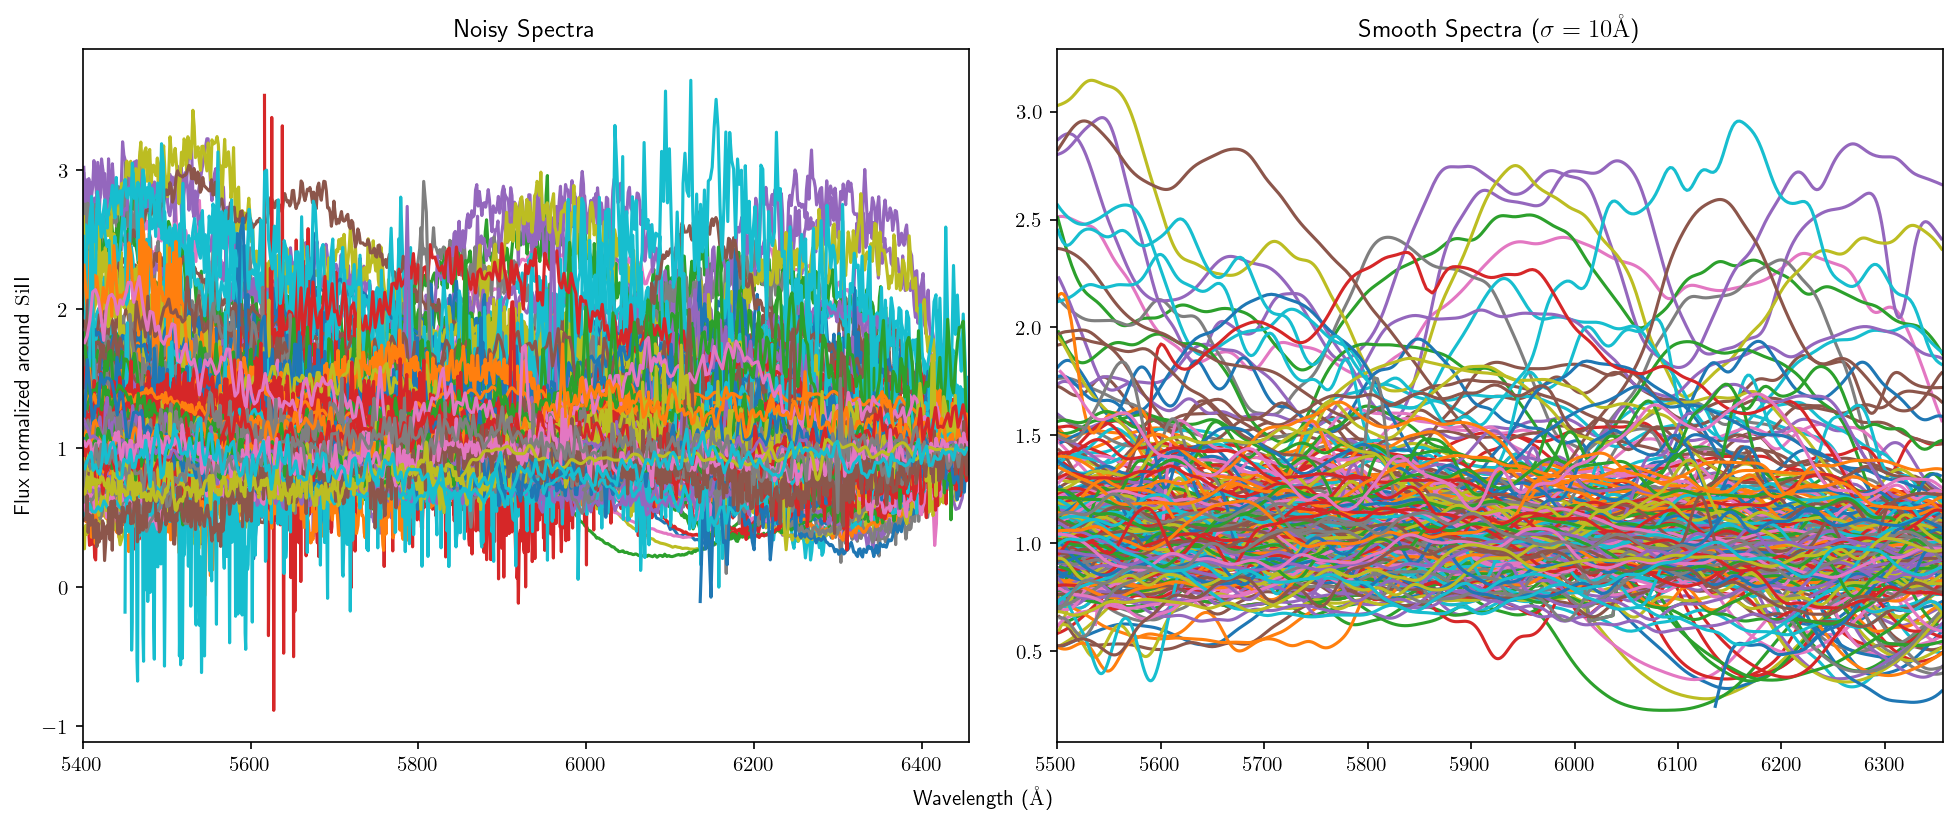

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(wspace=0.1)
axs[0].margins(x=0)
axs[1].margins(x=0)

axs[0].set_title("Noisy Spectra")
axs[1].set_title(r"Smooth Spectra ($\sigma={"+f'{smooth_sigma}'+r"\unit{\angstrom}}$)")
fig.text(0.5, 0.04, r'Wavelength ($\unit{\angstrom}$)', ha='center')
axs[0].set_ylabel(r'Flux normalized around $\ce{Si}\text{II}$')

#plot noisy spectra compared to smooth spectra for visualization
for i, row in enumerate(good_data):
    try:
        z = float(row['Redshift'])
        file = f'wiserep_data/{row['Ascii file']}'
        spec: Table = Table.read(f'{file}', format='ascii')
        spec: QTable = QTable([spec.columns[0], spec.columns[1]], names=['Wavelength', 'Flux'], units=[u.Angstrom, None]) #best way to read in the file without dealing with wierd errors
        while good_data['Mean Resolution'][i] < 0.1: #some spectra with higher resolution than necessary causing memory issues
            spec = spec[[bool(i%2) for i in range(len(spec))]]
            good_data['Mean Resolution'] = calculate_intervals(spec['Wavelength']).to_value().mean()
        spec['Wavelength'] *= (z + 1)
        spec = spec[(spec['Wavelength'] >= (5500-100)*u.Angstrom) & (spec['Wavelength'] <= si2+100*u.Angstrom)]
        range_mask = (spec['Wavelength'] >= (5500)*u.Angstrom) & (spec['Wavelength'] <= si2)
        if len(spec['Wavelength'][range_mask]) > 0:
            spec['Flux'] /= spec['Flux'][-1] #scale flux around the flux of the Si II line
            axs[0].plot(spec['Wavelength'], spec['Flux'])
            axs[1].plot(spec['Wavelength'][range_mask], smooth_data(spec['Wavelength'].to_value(), spec['Flux'], smooth_sigma)[range_mask])
    except (TypeError, ValueError, FileNotFoundError, astropy.io.ascii.InconsistentTableError, MemoryError) as e: #esoteric errors that I have not been able to solve
        pass
    progress_bar(i+1, len(good_data), 20)
plt.savefig('smoothed_spectra.png')

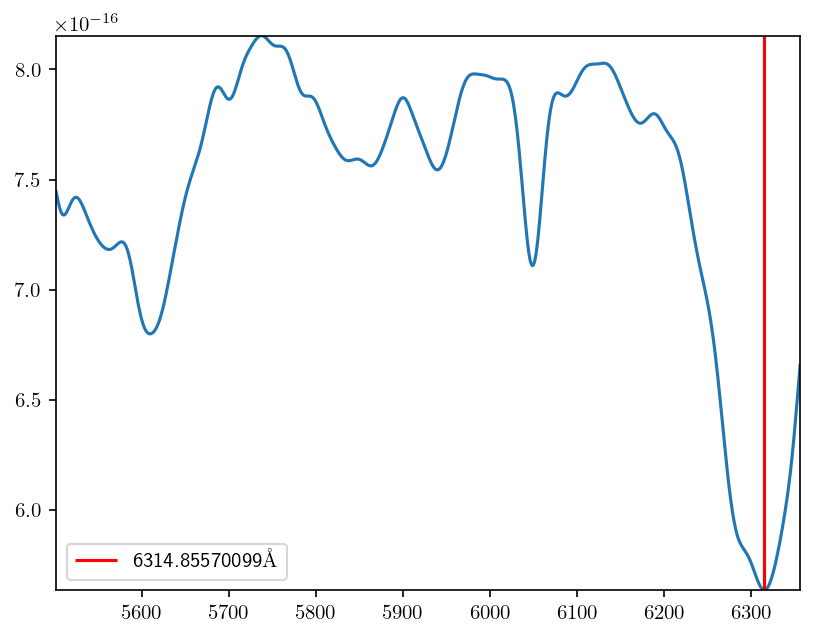

In [ ]:
#calculate and plot the siII absorption line of a randomly chosen spectrum
v_calculation_example = good_data[np.random.default_rng(15).integers(0, len(good_data))]
ex_spec: Table = Table.read(f'wiserep_data/{v_calculation_example['Ascii file']}', format='ascii')
ex_spec: QTable =  QTable([ex_spec.columns[0], ex_spec.columns[1]], names=['Wavelength', 'Flux'], units=[u.Angstrom, None])
ex_spec = ex_spec[(ex_spec['Wavelength'] > (5500 - 20)*u.Angstrom) & (ex_spec['Wavelength'] < si2 +20* u.Angstrom)]
ex_smooth = smooth_data(ex_spec['Wavelength'].to_value(), ex_spec['Flux'], smooth_sigma)
ex_smooth = ex_smooth[(ex_spec['Wavelength'] > 5500*u.Angstrom) & (ex_spec['Wavelength'] < si2)]
ex_spec = ex_spec[(ex_spec['Wavelength'] > 5500*u.Angstrom) & (ex_spec['Wavelength'] < si2)]
ex_min = argrelmin(ex_smooth, order=10)[0][-1]
ex_fig, ex_ax = plt.subplots()
ex_ax.margins(0)
ex_ax.plot(ex_spec['Wavelength'], ex_smooth)
ex_ax.vlines(ex_spec['Wavelength'][ex_min].to_value(), *ex_ax.get_ylim(), color='red', label=f'{ex_spec['Wavelength'][ex_min].to_value()}'+r'$\unit{\angstrom}$')
ex_ax.legend(bbox_to_anchor=(0, 0, 0.95, 1))
plt.savefig('ex_velocity.png')

In [ ]:
#define Kernel Density Estimation function (only for 1dimension)
def kde(data: np.ndarray, bins: int | np.ndarray = 100, sigma: float = 1.0) -> list[np.ndarray, np.ndarray]:
    '''
    Returns
    -------
    `list[x, y]`
    '''
    def kde_gaussian(grid: np.ndarray, center: float, sigma: float = 1.0):
        return np.exp(-((grid - center)**2) / (2*sigma))
    if isinstance(bins, np.ndarray):
        r = bins
    else:
        r = np.linspace(np.min(data) - 3*sigma, np.max(data) + 3*sigma, bins)
    
    values = np.zeros_like(r)

    #could probably make more efficient using broadcasting tricks, but works fine
    for d in data:
        values += kde_gaussian(r, d, sigma)
    
    return (r, values)

In [ ]:
#function to trim kde to ignore all low values on the outsides of the function
def trimmed_kde(data, bins, sigma, threshold):
    x, y = kde(data, bins, sigma)
    y[y < threshold] = 0
    mask = np.where(y != 0)[0]
    if len(mask) > 0:
        lead, trail = mask[0], mask[-1]
        return x[lead:trail+1], y[lead:trail+1]
    else:
        return x, y

In [21]:
def mean_median_mode(x, y, hist):
    mean = np.mean(y)
    median = np.median(y)
    mode = x[np.argmax(hist)]
    return mean, median, mode

In [ ]:
#reformat pythons scientific notation to be of form n*10^p to work with latex
def scientific_to_latex(num, sig_figs=1, big=True):
    try:
        parts = f'{num:.{sig_figs}e}'.split('e+')
        exp = 1
        if len(parts) == 1:
            parts = f'{num:.{sig_figs}e}'.split('e-')
            exp = -1
        if int(parts[1]) == 0:
            if big:
                return "$0$"
            else:
                return "$1$"
        exp = str(exp*int(parts[1]))
    except IndexError:
        print(parts)
        raise
    return f'{parts[0]}'+r'\cdot'+'10^{'+f'{exp}'+'}'

In [ ]:
#sort data according to supernova type
sn_types = ['SN Ia', 'SN Ia-91bg-like', 'SN Ia-91T-like']
data_by_type = [good_data[good_data['Obj. Type'] == t] for t in sn_types]
print([len(i) for i in data_by_type])

C:\Users\tobyh\AppData\Local\Temp\ipykernel_8372\2895854476.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ind_axs[i].legend(title=sn_types[i], loc='upper left')
C:\Users\tobyh\AppData\Local\Temp\ipykernel_8372\2895854476.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ind_ax_top.set_xticklabels([f'${scientific_to_latex(v)}$' for v in redshift_to_velocity(ind_axs[2].get_xticks(), ckms).to_value()], fontsize=10)
C:\Users\tobyh\AppData\Local\Temp\ipykernel_8372\2895854476.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  all_ax_top.set_xticklabels([f'${scientific_to_latex(v)}$' for v in redshift_to_velocity(all_ax.get_xticks(), ckms).to_value()], fontsize=10)


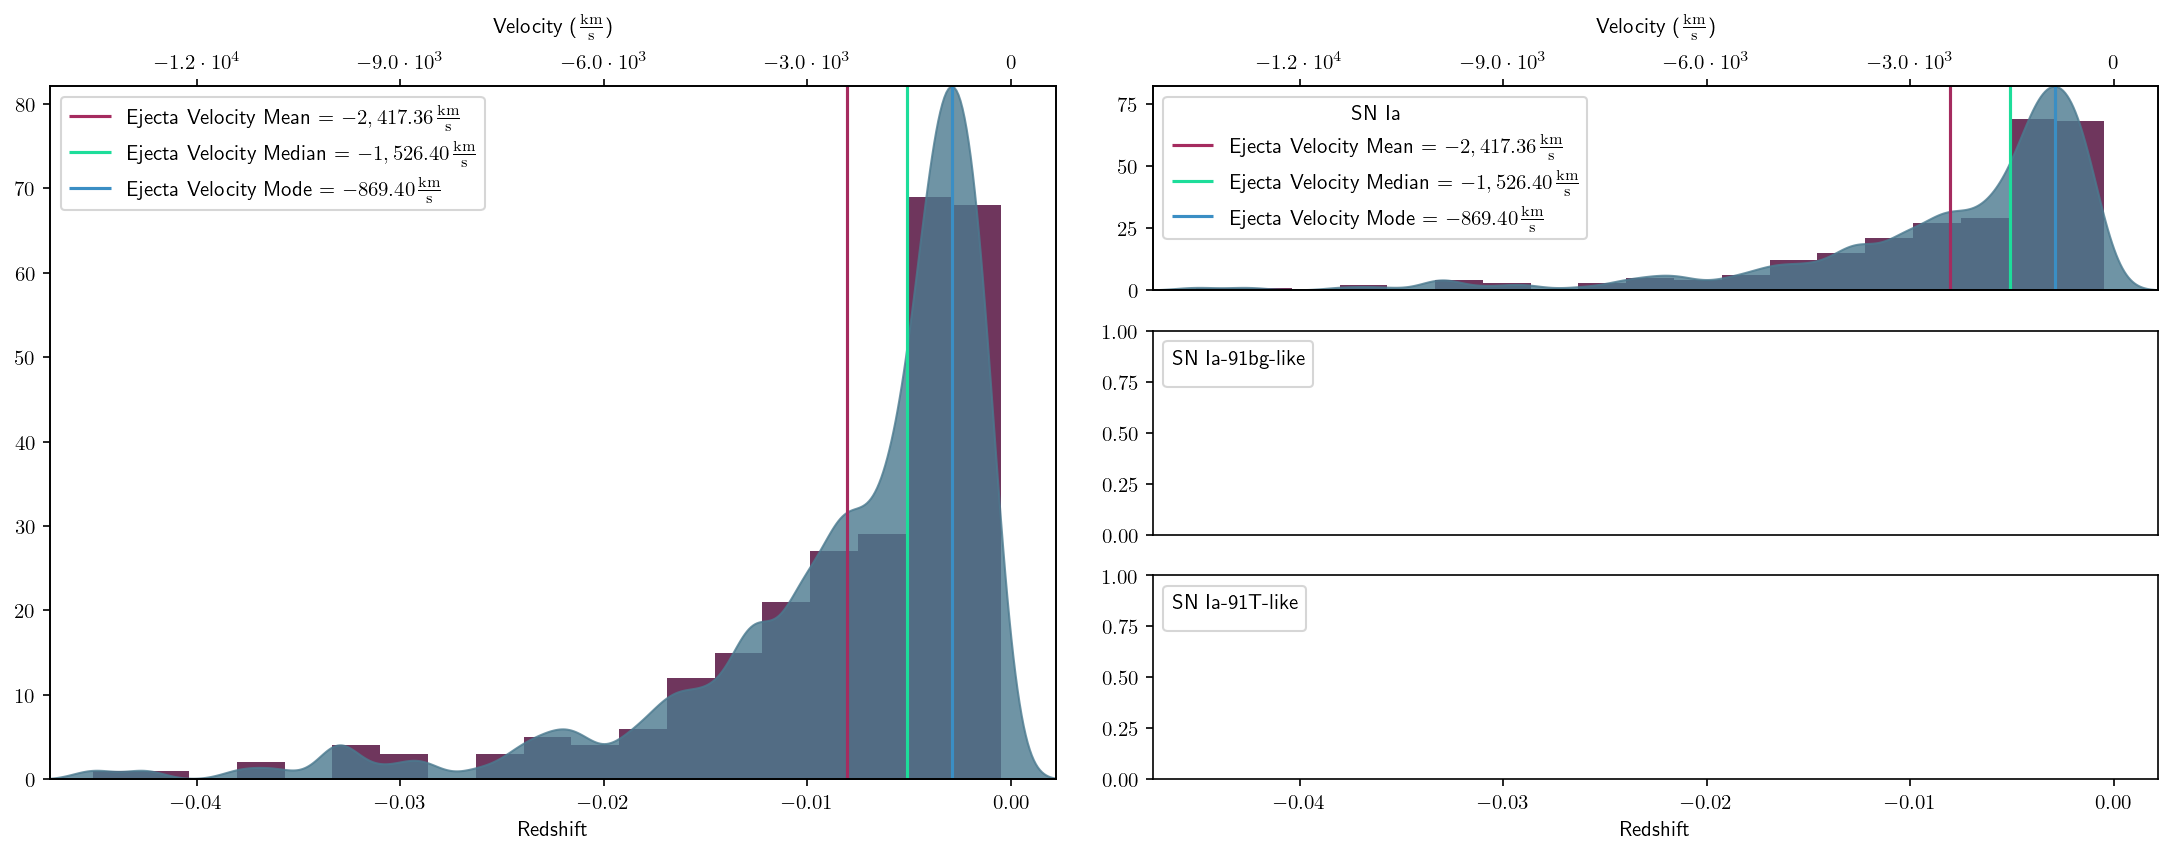

In [ ]:
fig = plt.figure(figsize=(16,6))
subfigs: np.ndarray[plt.Figure] = fig.subfigures(1, 2, wspace=-0.15)

ckms: Quantity = consts.c.to(u.km/u.s)

all_ax: mplax.Axes = subfigs[0].subplots(1, 1) #axes for plotting all data together
ind_axs: np.ndarray[mplax.Axes] = subfigs[1].subplots(3, 1) #axes for plotting data separated by subclassification

hist_col = "#6f365d"
kde_col = "#4b7a8f"
mean_col, med_col, mode_col = "#a52b5f", "#1ddd9a", "#3a8ec4"

#plot kde of all data unseparated
all_z, all_y = trimmed_kde(good_data['Ejecta Redshift'].data, np.arange(-0.2, 0.02, 0.0001), 1e-6, 0.1)
all_mean, all_median, all_mode = mean_median_mode(all_z, good_data['Ejecta Redshift'], all_y)

all_ax.margins(0)
all_ax.hist(good_data['Ejecta Redshift'], bins='auto', color=hist_col, alpha=1)
all_ax.fill_between(all_z, all_y, np.zeros_like(all_z), color=kde_col, alpha=0.8)
all_ax.vlines(all_mean, *all_ax.get_ylim(), color=mean_col, label=f'Ejecta Velocity Mean = ${redshift_to_velocity(all_mean, ckms).to_value() : ,.2f}'+r'\frac{\unit{km}}{\unit{s}}$')
all_ax.vlines(all_median, *all_ax.get_ylim(), color=med_col, label=f'Ejecta Velocity Median = ${redshift_to_velocity(all_median, ckms).to_value() : ,.2f}'+r'\frac{\unit{km}}{\unit{s}}$')
all_ax.vlines(all_mode, *all_ax.get_ylim(), color=mode_col, label=f'Ejecta Velocity Mode = ${redshift_to_velocity(all_mode, ckms).to_value() : ,.2f}'+r'\frac{\unit{km}}{\unit{s}}$')
all_ax.legend()

xlims = []
#plot kde of each subtype individually
for i, data in enumerate(data_by_type):
    if len(data)>0:
        ind_axs[i].hist(data['Ejecta Redshift'], bins='auto', color=hist_col, alpha=1)
        ind_axs[i].margins(0)
        kde_z, kde_y = trimmed_kde(data['Ejecta Redshift'].data, np.arange(-0.2, 0.02, 0.0001), 1e-6, 0.1)
        ind_axs[i].fill_between(kde_z, kde_y, np.zeros_like(kde_z), color=kde_col, alpha=0.8)
        mean, med, mode = mean_median_mode(kde_z, data['Ejecta Redshift'], kde_y)

        ind_axs[i].vlines(mean, *ind_axs[i].get_ylim(), color=mean_col, label=f'Ejecta Velocity Mean = ${redshift_to_velocity(mean, ckms).to_value() : ,.2f}'+r'\frac{\unit{km}}{\unit{s}}$')
        ind_axs[i].vlines(med, *ind_axs[i].get_ylim(), color=med_col, label=f'Ejecta Velocity Median = ${redshift_to_velocity(med, ckms).to_value() : ,.2f}'+r'\frac{\unit{km}}{\unit{s}}$')
        ind_axs[i].vlines(mode, *ind_axs[i].get_ylim(), color=mode_col, label=f'Ejecta Velocity Mode = ${redshift_to_velocity(mode, ckms).to_value() : ,.2f}'+r'\frac{\unit{km}}{\unit{s}}$')
        [xlims.append(ind_axs[i].get_xlim()[q]) for q in [0,1]]
    ind_axs[i].legend(title=sn_types[i], loc='upper left')

ind_axs[2].set_xlabel(r'Redshift')

#bunch of tricks to get plt's formatting to display velocity on top
for ax in ind_axs:
    ax.set_xlim(np.min(xlims), np.max(xlims))

ind_ax_top: mplax.Axes = ind_axs[0].twiny()
ind_ax_top.set_xlabel(r'Velocity ($\frac{\unit{km}}{\unit{s}}$)', labelpad=10)
ind_ax_top.set_xlim(ind_axs[2].get_xlim())
ind_ax_top.set_xticklabels([f'${scientific_to_latex(v)}$' for v in redshift_to_velocity(ind_axs[2].get_xticks(), ckms).to_value()], fontsize=10)
ind_axs[0].xaxis.set_visible(False)
ind_axs[1].xaxis.set_visible(False)

all_ax_top: mplax.Axes = all_ax.twiny()
all_ax_top.set_xlabel(r'Velocity ($\frac{\unit{km}}{\unit{s}}$)', labelpad=10)
all_ax_top.set_xlim(all_ax.get_xlim())

all_ax_top.set_xticklabels([f'${scientific_to_latex(v)}$' for v in redshift_to_velocity(all_ax.get_xticks(), ckms).to_value()], fontsize=10)
all_ax.set_xlabel(r'Redshift')

plt.savefig('kdes.png')

In [ ]:
#define a model to fit data to. model is a piecewise function with a half gaussian at x<=x0 and a tanh easing function at x>x0
def lower_half_gauss_model(x, x0, amp, sig_gauss, sig_ease):
    model = np.where(x <= x0, amp * np.exp((-(x-x0)**2)/(2*(sig_gauss**2))), (amp/2)*(1-np.tanh((sig_ease)*(x-x0)-4)))
    return model
fits, fits_cov = curve_fit(lower_half_gauss_model, all_z, all_y, p0=(-0.01, 80, 0.01, 1))
sigma_fit = scientific_to_latex(fits[2], 2)
print(fits)

[-2.15352694e-03  6.55371375e+01  5.73873877e-03  2.42612485e+03]


C:\Users\tobyh\AppData\Local\Temp\ipykernel_8372\2558899871.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_top.set_xticklabels([f'${scientific_to_latex(v)}$' for v in redshift_to_velocity(ax.get_xticks(), ckms).to_value()], fontsize=10)


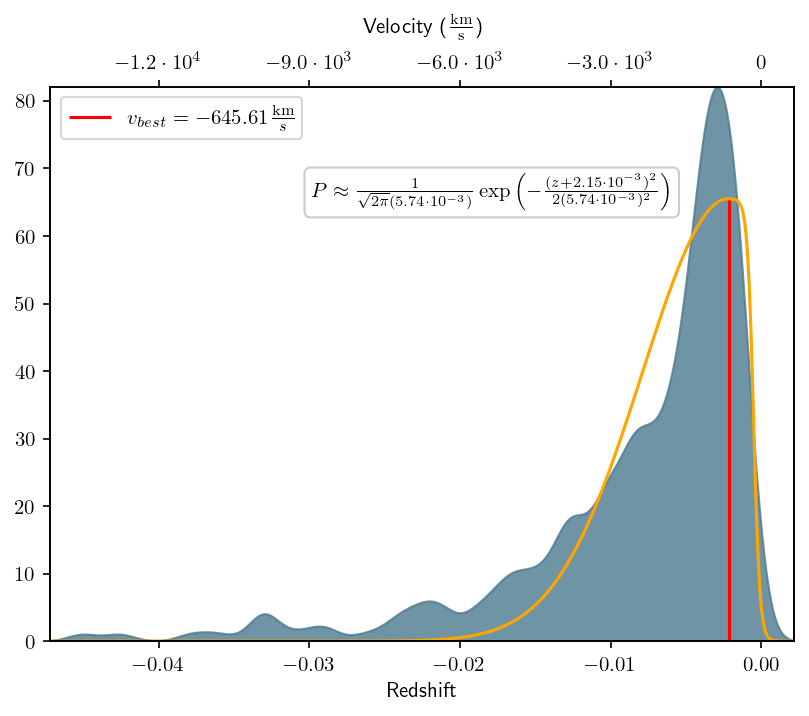

In [ ]:
#plot best fit model over the KDE
fig, ax = plt.subplots()
ax.margins(0)
ax.fill_between(all_z, all_y, np.zeros_like(all_z), color=kde_col, alpha=0.8)
ax.vlines(fits[0], ymin=np.min(kde_y), ymax=lower_half_gauss_model(0, 0, fits[1], fits[2], fits[3]), color='red',
          label=r'$v_{best}='+f'{redshift_to_velocity(fits[0], ckms).to_value():.2f}'+r'\frac{\unit{km}}{s}$')
sign = '-' if fits[0]>0 else '+'
z0 = abs(fits[0])
ax.plot(all_z, lower_half_gauss_model(all_z, *fits), color='orange')

ax.text(0.35, 0.8, r'$P\approx \frac{2}{\sqrt{2\pi}('+f'{sigma_fit})'+r'}\exp\left(-\frac{(z'+f'{sign}{scientific_to_latex(z0, 2)})^2'+'}{2('+f'{sigma_fit}'+r')^2}\right)$',
            transform=ax.transAxes, bbox={'boxstyle':'round', 'facecolor':'none', 'edgecolor':'#cccccc'})

ax_top: mplax.Axes = ax.twiny()
ax_top.set_xlabel(r'Velocity ($\frac{\unit{km}}{\unit{s}}$)', labelpad=10)
ax_top.set_xlim(ax.get_xlim())
ax_top.set_xticklabels([f'${scientific_to_latex(v)}$' for v in redshift_to_velocity(ax.get_xticks(), ckms).to_value()], fontsize=10)
ax.set_xlabel(r'Redshift')
ax.legend()
plt.savefig('gaussian_bestfit.png')

*Clustering*

C:\Users\tobyh\AppData\Local\Temp\ipykernel_8372\55777723.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cluster_ax_top.set_xticklabels([f'${scientific_to_latex(v)}$' for v in redshift_to_velocity(cluster_ax.get_xticks(), ckms).to_value()], fontsize=10)


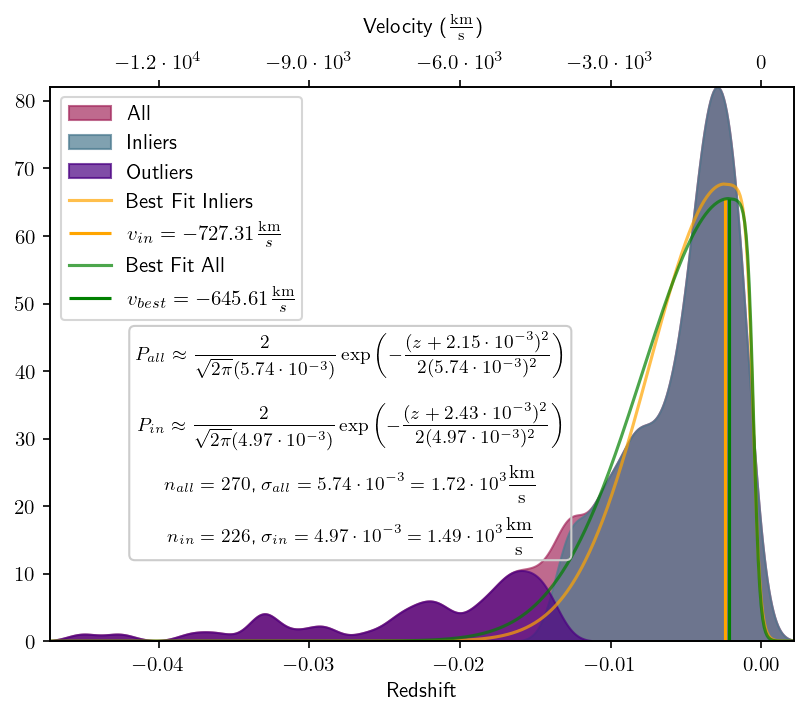

In [ ]:
#try to cluster to get rid of incorrectly calculated absorption lines, and compare it to without the incorrect calculation
kmeans2 = KMeans(n_clusters=2)
clusters2 = kmeans2.fit_predict(good_data['Ejecta Redshift'].data.reshape(-1, 1))
in_mask = clusters2 == (0 if clusters2.sum() < len(clusters2)/2 else 1) #identify inliers as the larger group
inliers = good_data['Ejecta Redshift'][in_mask]
outliers = good_data['Ejecta Redshift'][np.bitwise_not(in_mask)]

#all this code is doing is the same as the plot above, but twice.
in_kde_z, in_kde_y = trimmed_kde(inliers, np.arange(-0.2, 0.02, 0.0001), 1e-6, 0.1)
out_kde_z, out_kde_y = trimmed_kde(outliers, np.arange(-0.2, 0.02, 0.0001), 1e-6, 0.1)

in_fits, in_fits_cov = curve_fit(lower_half_gauss_model, in_kde_z, in_kde_y)
sigma_in_fit = scientific_to_latex(abs(in_fits[2]), 2)
in_sign = '-' if in_fits[0]>0 else '+'
in_z0 = abs(in_fits[0])

cluster_fig, cluster_ax = plt.subplots()
cluster_ax.margins(0)

cluster_ax.fill_between(all_z, all_y, np.zeros_like(all_z), label='All', color=mean_col, alpha=0.7) #plot all
cluster_ax.fill_between(in_kde_z, in_kde_y, np.zeros_like(in_kde_z), label='Inliers', color=kde_col, alpha=0.7), #plot clustered inliers
cluster_ax.fill_between(out_kde_z, out_kde_y, np.zeros_like(out_kde_z), label='Outliers', color='indigo', alpha=0.7) #plot clustered outliers

cluster_ax.plot(all_z, lower_half_gauss_model(all_z, *in_fits), color='orange', label='Best Fit Inliers', alpha=0.7) #use x values from all with the model
cluster_ax.vlines(in_fits[0], ymin=np.min(in_kde_y), ymax=lower_half_gauss_model(0, 0, *fits[1:]), color='orange',
                  label=r'$v_{in}='+f'{redshift_to_velocity(in_fits[0], ckms).to_value():.2f}'+r'\frac{\unit{km}}{s}$')

cluster_ax.plot(all_z, lower_half_gauss_model(all_z, *fits), color='green', label="Best Fit All", alpha=0.7)
cluster_ax.vlines(fits[0], ymin=np.min(kde_y), ymax=lower_half_gauss_model(0, 0, *fits[1:]), color='green',
                  label=r'$v_{best}='+f'{redshift_to_velocity(fits[0], ckms).to_value():.2f}'+r'\frac{\unit{km}}{s}$')
cluster_ax.legend()

#create textbox to display probability functions and standard deviations
cluster_ax.text(0.02, 0.5, 
            r'$$P_{all}\approx \frac{2}{\sqrt{2\pi}('+f'{sigma_fit})'+r'}\exp\left(-\frac{(z'+f'{sign}{scientific_to_latex(z0, 2)})^2'+'}{2('+f'{sigma_fit}'+r')^2}\right)$$'+
            r'$$P_{in}\approx \frac{2}{\sqrt{2\pi}('+f'{sigma_in_fit})'+r'}\exp\left(-\frac{(z'+f'{in_sign}{scientific_to_latex(in_z0, 2)})^2'+'}{2('+f'{sigma_in_fit}'+r')^2}\right)$$'+
            r'$$n_{all}='+f'{len(good_data)}'+r'\text{, }'+ r'\sigma_{all}='+f'{sigma_fit}={scientific_to_latex(redshift_to_velocity(fits[2], ckms).to_value(), 2)}'+r'\frac{\unit{km}}{\unit{s}}$$'+
            r'$$n_{in}='+f'{int(np.sum(in_mask))}'+r'\text{, }\sigma_{in}='+f'{sigma_in_fit}={scientific_to_latex(redshift_to_velocity(abs(in_fits[2]), ckms).to_value(), 2)}'+r'\frac{\unit{km}}{\unit{s}}$$',
            transform=ax.transAxes, bbox={'boxstyle':'round', 'facecolor':'none', 'edgecolor':'#cccccc'}, fontsize=9)

cluster_ax_top: mplax.Axes = cluster_ax.twiny()
cluster_ax_top.set_xlabel(r'Velocity ($\frac{\unit{km}}{\unit{s}}$)', labelpad=10)
cluster_ax_top.set_xlim(cluster_ax.get_xlim())
cluster_ax_top.set_xticklabels([f'${scientific_to_latex(v)}$' for v in redshift_to_velocity(cluster_ax.get_xticks(), ckms).to_value()], fontsize=10)
cluster_ax.set_xlabel(r'Redshift')
plt.savefig('clustered_bestfit.png')